In [10]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [36]:
def time2timestamp(x, rate):
    return np.round(x * rate).astype(int)

def extract_trails(time_trails, time_range):
    res_list = []
    for time_trail in time_trails:
        if ((time_trail[0] > time_range[0]) and (time_trail[0] < time_range[1])) or ((time_trail[1] > time_range[0]) and (time_trail[1] < time_range[1])):
            res_list.append([np.max([time_trail[0], time_range[0]]), np.min([time_trail[1], time_range[1]])])
    return np.stack(res_list)

def create_datasets(X_list, Y_list, channel_indexes=None):
    M = len(Y_list)
    Xlist = list()
    Ylist = list()
    if channel_indexes is None:
        channel_indexes = np.arange(M)
    for i in channel_indexes:
        Xlist.append(X_list[i])
        Ylist.append(Y_list[i])
    return Xlist, Ylist

with open("../../data/ECoG/78_channel_indexes.pickle", "rb") as res:
    channel_indexes = pickle.load(res)

# load data
# data_loc = "../../data/Poly/R70_B8_Wvlt_4to1200_54band_CAR0_Poly_high_gamma_2s.pickle"
# data_loc = "../../data/ECoG/R32_B7_Hilb_54bands_ECoG_high_gamma_2s.pickle"
# data_loc = "../../data/ECoG/R32_B8_Hilb_54bands_ECoG_high_gamma_2s.pickle"
data_loc = "../../data/ECoG/R32_B7_Hilb_54bands_ECoG_high_gamma.pickle"
# data_loc = "../../data/ECoG/R32_B8_Hilb_54bands_ECoG_high_gamma.pickle"
with open(data_loc, "rb") as res:
    times, band_resps, time_trials = pickle.load(res)
    # times, band_resp = pickle.load(res)

N, M = band_resps.shape
print("number of timestamps: {}, dimension size: {}".format(N, M))

time_start=14.
time_stop=19.
rate = 400.

time_interval = np.linspace(time_start, time_stop, num=int((time_stop - time_start) * (rate)), endpoint=False)
timestamps_interval = time2timestamp(time_interval, rate)
time_range = np.array([time_interval[0], time_interval[-1]])
time_trials = extract_trails(time_trials, time_range)
times = times[timestamps_interval]
band_resps = band_resps[timestamps_interval]

N, M = band_resps.shape

from sklearn import preprocessing
X_list = list()
Y_list = list()
for i in range(M):
    X_list.append(np.arange(N))
    Y_list.append(preprocessing.scale(band_resps[:, i]))

X_list, Y_list = create_datasets(X_list, Y_list, channel_indexes=channel_indexes)

n_channel = 25
n_dims = n_channel
pre_name = "full_data{}".format(n_channel)
# convert data format
X_train_origin_list = [x[:, None] for x in X_list]
Y_train_origin_list = [y[:, None] for y in Y_list]
X_train_list = X_train_origin_list[:n_dims]
Y_train_list = Y_train_origin_list[:n_dims]

number of timestamps: 120000, dimension size: 128


In [42]:
X_list[0].shape
Y_list[0].shape
N, M = band_resps.shape

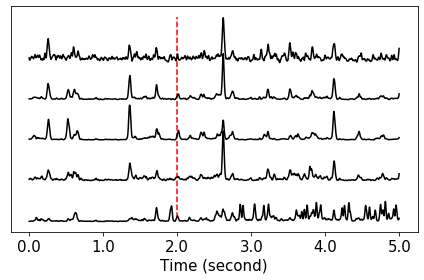

In [43]:
illustration_list = np.diag(np.arange(25).reshape(5,5))
gap=10
fig = plt.figure()
ax = fig.add_subplot(111)
for index, i in enumerate(illustration_list):
    ax.plot(X_train_list[i], Y_train_list[i] - gap*index, 'k', mew=1.5)
ax.vlines(x=800, ymin=-40, ymax=10, colors='r', linestyles="dashed")
ax.set_yticks(ticks=[])
ax.set_xticks(ticks=np.linspace(0,2000,num=6))
ax.set_xticklabels(labels=np.linspace(0,5,num=6), fontdict={"fontsize":15})
ax.set_xlabel("Time (second)", fontsize=15)
plt.tight_layout()
plt.savefig("../../res/ECoG/full_data25/raw_plot.png")
plt.show()


No handles with labels found to put in legend.


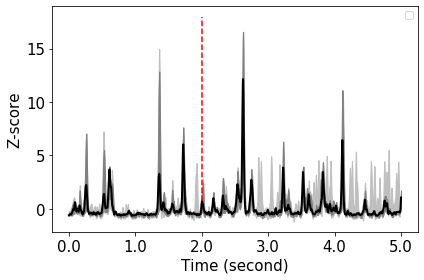

In [50]:
import statsmodels.api as sm
fig = plt.figure()
ax = fig.add_subplot(111)
# import pdb; pdb.set_trace()
res = sm.graphics.fboxplot(band_resps[:,channel_indexes].T, wfactor=1000., labels=channel_indexes, ax=ax)
ax.set_xlabel("Time (second)", fontsize=15)
ax.set_ylabel("Z-score", fontsize=15)
ax.set_xticks(ticks=np.linspace(0,2000,num=6))
ax.set_xticklabels(labels=np.linspace(0,5,num=6), fontdict={"fontsize":15})
ax.tick_params(labelsize=15)
ax.vlines(x=800, ymin=0, ymax=18, colors='r', linestyles="dashed")
plt.tight_layout()
fig.savefig("../../res/ECoG/full_data25/functional_boxplot.png")
plt.show()

In [11]:
# test_index = np.random.choice(N, int(0.2*N), replace=False)
# train_index = np.array(list(set(np.arange(N)) - set(test_index)))
# Xtrain_list = [X_list[0][train_index]] + X_list[1:]
# Ytrain_list = [Y_list[0][train_index]] + Y_list[1:]
# Xtest_list = [X_list[0][test_index]] + [np.array([]) for i in range(M-1)]
# Ytest_list = [Y_list[0][test_index]] + [np.array([]) for i in range(M-1)]
with open("../../data/ECoG/data_R32_B8.pickle", "wb") as res:
    pickle.dump([X_list, Y_list], res)
# with open("../../data/ECoG/data_R32_B8.pickle", "wb") as res:
#     pickle.dump([X_list, Y_list], res)

train_index = np.arange(int(0.8*N))
test_index = np.array(list(set(np.arange(N)) - set(train_index)))
Xtrain_list = [X_list[0][train_index]] + X_list[1:]
Ytrain_list = [Y_list[0][train_index]] + Y_list[1:]
Xtest_list = [X_list[0][test_index]] + [np.array([]) for i in range(M-1)]
Ytest_list = [Y_list[0][test_index]] + [np.array([]) for i in range(M-1)]
with open("../../data/ECoG/data_extrapolation.pickle", "wb") as res:
    pickle.dump([Xtrain_list, Ytrain_list, Xtest_list, Ytest_list], res)